## Introduction
A young venture capitalist is interested in investing into a hot new restaurant in Brooklyn, NY. This will be a new construction and investment. Finding the best neighborhood is based on number of restaurants and what type of restaurants are within a neighborhood

The data will come from the data from Segmentation and Clustering lab for New York and will focus on the borough of Brooklyn. Foursquare data will also be integrated to get coordinates and venue info to establish a better idea in which what area in Brooklyn would be the best to invest in.

In [3]:
#first, let's install all libraries that we need
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.18.1               |             py_0          51 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          84 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge


geopy-1.18.1         | 51 KB     | ##################################### | 100% 
geographiclib-1.49   | 32 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  envi

<a id='item1'></a>

Luckily, New York City  dataset exists for free on the web.
https://geo.nyu.edu/catalog/nyu_2451_34572

I downloaded the files and placed it on the server to import easier.

In [2]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [8]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [9]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [10]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [11]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [12]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [13]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [14]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In [15]:
address = 'New York City, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of New York City are 40.7308619, -73.9871558.


#### Create a map of New York with neighborhoods superimposed on top.

In [17]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [16]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


Let's get the geographical coordinates of Manhattan.

In [17]:
address = 'Brooklyn, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [20]:
# create map of Brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [18]:
CLIENT_ID = 'ORJ4K1W3IW3A50CGBGY3LY4SN0NMECQNSZJ2FN2M2UHWIUFG' # your Foursquare ID
CLIENT_SECRET = 'B4IFZSJU4DRSW4Z2CG5RRF1DYM41NU2B04DFPBFSBHUSNH42' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ORJ4K1W3IW3A50CGBGY3LY4SN0NMECQNSZJ2FN2M2UHWIUFG
CLIENT_SECRET:B4IFZSJU4DRSW4Z2CG5RRF1DYM41NU2B04DFPBFSBHUSNH42


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [19]:
brooklyn_data.loc[0, 'Neighborhood']

'Bay Ridge'

Get the neighborhood's latitude and longitude values.

In [20]:
neighborhood_latitude = brooklyn_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = brooklyn_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = brooklyn_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bay Ridge are 40.625801065010656, -74.03062069353813.


#### Now, let's get the top 100 venues that are in Brooklyn within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [21]:
# type your answer here
#<!-- The correct answer is:
LIMIT = 20 # limit of number of venues returned by Foursquare API
#-->

#<!--
radius = 500 # define radius
#-->

##\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
#--> 




'https://api.foursquare.com/v2/venues/explore?&client_id=ORJ4K1W3IW3A50CGBGY3LY4SN0NMECQNSZJ2FN2M2UHWIUFG&client_secret=B4IFZSJU4DRSW4Z2CG5RRF1DYM41NU2B04DFPBFSBHUSNH42&v=20180605&ll=40.625801065010656,-74.03062069353813&radius=500&limit=20'

In [22]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c1b1860f594df03ec9b713b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Ridge',
  'headerFullLocation': 'Bay Ridge, Brooklyn',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 92,
  'suggestedBounds': {'ne': {'lat': 40.63030106951066,
    'lng': -74.02470273356597},
   'sw': {'lat': 40.62130106051065, 'lng': -74.03653865351028}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b895827f964a5206c2d32e3',
       'name': 'Pilo Arts Day Spa and Salon',
       'location': {'address': '8412 3rd Ave',
        'lat': 40.62474788273414,
        'lng': -74.03059056940135,
        'labeledLatL

Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [23]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [24]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Pilo Arts Day Spa and Salon,Spa,40.624748,-74.030591
1,Bagel Boy,Bagel Shop,40.627896,-74.029335
2,Cocoa Grinder,Juice Bar,40.623967,-74.030863
3,Pegasus Cafe,Breakfast Spot,40.623168,-74.031186
4,Ho' Brah Taco Joint,Taco Place,40.622960,-74.031371


In [25]:
#let's see how many venues returned
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

20 venues were returned by Foursquare.


<a id='item2'></a>

## 2. Explore Neighborhoods in Brooklyn

#### Let's create a function to repeat the same process to all the neighborhoods in Brooklyn

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [27]:
# type your answer here

brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )



Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [28]:
#### Let's check the size of the resulting dataframe
print(brooklyn_venues.shape)
brooklyn_venues.head()

(1231, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place


Let's check how many venues were returned for each neighborhood

In [29]:
##Let's check how many venues were returned for each neighborhood
brooklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,20,20,20,20,20,20
Bay Ridge,20,20,20,20,20,20
Bedford Stuyvesant,20,20,20,20,20,20
Bensonhurst,20,20,20,20,20,20
Bergen Beach,6,6,6,6,6,6
Boerum Hill,20,20,20,20,20,20
Borough Park,20,20,20,20,20,20
Brighton Beach,20,20,20,20,20,20
Broadway Junction,15,15,15,15,15,15


#### Let's find out how many unique categories can be curated from all the returned venues

In [30]:
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 219 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [41]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.head()

,Yoga Studio,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Garden,Beer Store,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Varenyky restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [43]:
brooklyn_onehot.shape

(1231, 220)

In [44]:
#let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').sum()
brooklyn_grouped

,Yoga Studio,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Garden,Beer Store,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Varenyky restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Total Restaurants
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bath Beach,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,7
Bay Ridge,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Let's confirm the new size

In [45]:
brooklyn_grouped.shape

(70, 219)

## 4. k-means ML Experiment

In [46]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# run k-means clustering
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(brooklyn_grouped)

In [47]:
means_df = pd.DataFrame(kmeans.cluster_centers_)
means_df.columns = brooklyn_grouped.columns
means_df.index = ['K1','K2','K3','K4','K5']
means_df['Total Sum'] = means_df.sum(axis = 1)
means_df.sort_values(axis = 0, by = ['Total Sum'], ascending=False)

#K5 shows as the best group

,Yoga Studio,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Garden,Beer Store,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Varenyky restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Total Restaurants,Total Sum
K5,0.375000,0.000000,-6.938894e-18,1.250000e-01,-1.734723e-18,1.387779e-17,-6.938894e-18,1.387779e-17,-6.938894e-18,-1.734723e-18,-6.938894e-18,0.250000,0.250000,0.375000,0.750000,1.250000e-01,-1.734723e-18,-1.734723e-18,-1.387779e-17,-3.469447e-18,-1.734723e-18,-3.469447e-18,1.250000e-01,-1.734723e-18,-1.734723e-18,1.250000e-01,1.387779e-17,-1.734723e-18,-1.734723e-18,0.125000,-3.469447e-18,-1.387779e-17,-6.938894e-18,-3.469447e-18,0.000000,-1.734723e-18,-6.938894e-18,-1.734723e-18,1.125000,-1.734723e-18,-1.734723e-18,0.375000,-1.734723e-18,5.000000e-01,2.500000e-01,0.875000,-3.469447e-18,-3.469447e-18,-1.387779e-17,1.387779e-17,1.250000e-01,2.500000e-01,-3.469447e-18,0.375000,0.125000,0.000000,0.000000,1.250000e-01,-1.734723e-18,1.250000e-01,1.250000e-01,0.375000,-1.734723e-18,1.250000e-01,-1.734723e-18,-3.4694

In [76]:
#lets find a the group for each neighbourhood
neigh_summary = pd.DataFrame([brooklyn_grouped.index, 1 + kmeans.labels_]).T
neigh_summary.columns = ['Neighborhood', 'Group']
neigh_summary

,Neighborhood,Group
0,Bath Beach,1
1,Bay Ridge,1
2,Bedford Stuyvesant,4
3,Bensonhurst,1
4,Bergen Beach,2
5,Boerum Hill,1
6,Borough Park,3
7,Brighton Beach,1
8,Broadway Junction,2
9,Brooklyn Heights,1


In [77]:
neigh_summary[neigh_summary['Group'] == 5]

,Neighborhood,Group
11,Bushwick,5
19,Cypress Hills,5
20,Ditmas Park,5
28,Flatbush,5
30,Fort Greene,5
56,Prospect Park South,5
62,South Side,5
64,Sunset Park,5


In [84]:
#lets export the data to csv
means_df.to_csv('brooklyn_venues.csv')

In [90]:
brooklyn_venues = pd.read_csv('brooklyn_venues.csv')

In [91]:
brooklyn_venues.head()

,kmean,Total Restaurants,Total Sum
0,K1,6.533333,26.400000
1,K2,1.458333,15.208333
2,K3,4.000000,22.333333
3,K4,3.545455,23.545455
4,K5,7.500000,27.500000


In [105]:
brooklyn_final = brooklyn_venues[['kmean','Total Restaurants','Total Sum']]

In [106]:
brooklyn_final.head()

,kmean,Total Restaurants,Total Sum
0,K1,6.533333,26.400000
1,K2,1.458333,15.208333
2,K3,4.000000,22.333333
3,K4,3.545455,23.545455
4,K5,7.500000,27.500000


In [92]:
#let plot this data

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0


Matplotlib version:  3.0.2


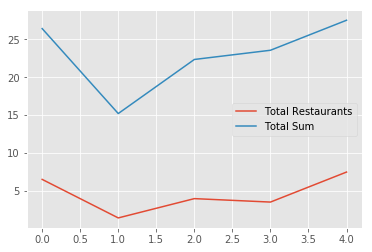

In [108]:
# plot bar chart
lines = brooklyn_final.plot.line()

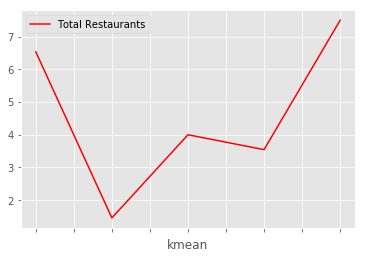

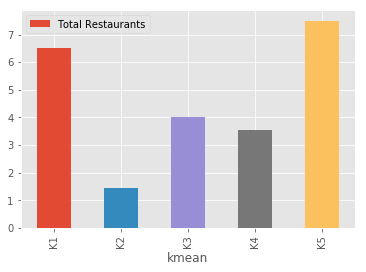

In [118]:
# a scatter plot comparing num_children and num_pets
brooklyn_final.plot(kind='line',x='kmean',y='Total Restaurants',color='red')
plt.show()

brooklyn_final.plot(kind='bar',x='kmean',y='Total Restaurants')

<hr>
Copyright &copy; 2018 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).